In [1]:
import math
from typing import List, Union

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from omegaconf import OmegaConf
from torch.cuda.amp import autocast
from torch.nn import CTCLoss

import os
import os.path as osp
from glob import glob
from tqdm.auto import tqdm
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

import sys
sys.path.append('/root/mediazen/s2b/')

from src.dataset import FaceDataset
from src.utils import plot_spectrogram, plot_result

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
# dataset

data_dir = '/root/mediazen/speech2anim/essentials_1443'
essentials_dir = [d.path for d in os.scandir(data_dir)]
audio_path, shape_path = essentials_dir
audio_path, shape_path

audio_pt = torch.load(audio_path)
shape_pt = torch.load(shape_path)

ds = FaceDataset(audio_pt[2], audio_pt[3], shape_pt[3], shape_pt[4], (audio_pt[1], shape_pt[0]))

In [3]:
class MaskConv(nn.Module):
    def __init__(self, seq_module):
        super(MaskConv, self).__init__()
        self.seq_module = seq_module

    def forward(self, x, lengths):
        """
        :param x: The input of size BxCxDxT
        :param lengths: The actual length of each sequence in the batch
        :return: Masked output from the module
        """
        for module in self.seq_module:
            x = module(x)
            mask = torch.BoolTensor(x.size()).fill_(0)
            if x.is_cuda:
                mask = mask.cuda()
            for i, length in enumerate(lengths):
                length = length.item()
                if (mask[i].size(2) - length) > 0:
                    mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
            x = x.masked_fill(mask, 0)
        return x, lengths

conv = MaskConv(nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)
        ))

In [4]:
idx = 7
sample_data = ds[idx]
spec, spec_len, blendshape, blendshape_len, idx, timecode = sample_data

def get_seq_lens(conv, input_length):
    """
    Given a 1D Tensor or Variable containing integer sequence lengths, return a 1D tensor or variable
    containing the size sequences that will be output by the network.
    :param input_length: 1D Tensor
    :return: 1D Tensor scaled by model
    """
    seq_len = input_length
    for m in conv.modules():
        if type(m) == nn.modules.conv.Conv2d:
            seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) // m.stride[1] + 1)
    return seq_len.int()

blendshape_len.unsqueeze(0), get_seq_lens(conv, spec_len.unsqueeze(0).cpu().int()), spec_len.unsqueeze(0)

(tensor([4409], dtype=torch.int32),
 tensor([3672], dtype=torch.int32),
 tensor([7343], dtype=torch.int32))

In [5]:
x, lengths = spec.unsqueeze(0), get_seq_lens(conv, spec_len.unsqueeze(0).cpu().int())
lengths = lengths.cpu().int()
x = x.unsqueeze(1) # 1, 1, 8376, 161
x = x.permute(0, 1, 3, 2) # 1, 1, 161, 8376

In [6]:
conv1 = nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
x_conv1_out = conv1(x)
x_conv1_out.shape

torch.Size([1, 32, 81, 5841])

In [7]:
mask = torch.BoolTensor(x_conv1_out.size()).fill_(0)
mask.shape

torch.Size([1, 32, 81, 5841])

In [8]:
for i, length in enumerate(lengths):
    length = length.item()
    # mask[i].shape : channel * freq * time
    if (mask[i].size(2) - length) > 0: # time(4188) - length(2781)
        mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)

In [9]:
x_conv1_out_masked = x_conv1_out.masked_fill(mask, 0)

In [10]:
x_conv1_out_masked.shape

torch.Size([1, 32, 81, 5841])

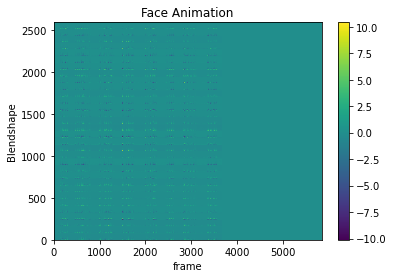

In [14]:
plot_result(x_conv1_out_masked[0].view(-1, x_conv1_out_masked.shape[-1]).detach())

In [12]:
batch_act1 = MaskConv(nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)))
x_1_masked, lengths = batch_act1(x_conv1_out_masked, lengths)
x_1_masked.shape

torch.Size([1, 32, 81, 5841])

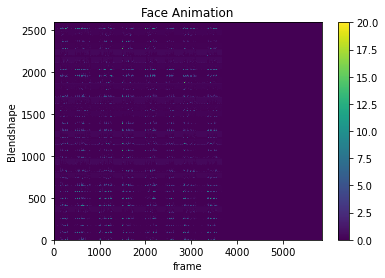

In [15]:
plot_result(x_1_masked[0].view(-1, 5841).detach())

In [16]:
conv2 = nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
x_conv2_out = conv2(x_1_masked)
x_conv2_out.shape

torch.Size([1, 32, 41, 5841])

In [17]:
mask = torch.BoolTensor(x_conv2_out.size()).fill_(0)
mask.shape

torch.Size([1, 32, 41, 5841])

In [18]:
for i, length in enumerate(lengths):
    length = length.item()
    # mask[i].shape : channel * freq * time
    if (mask[i].size(2) - length) > 0: # time(4188) - length(2781)
        mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)

In [19]:
x_conv2_out_masked = x_conv2_out.masked_fill(mask, 0)
x_conv2_out_masked.shape

torch.Size([1, 32, 41, 5841])

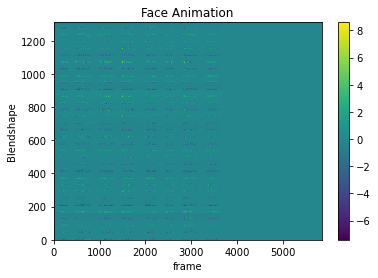

In [20]:
plot_result(x_conv2_out_masked[0].view(-1, 5841).detach())

In [21]:
batch_act2 = MaskConv(nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)))
x_2_masked, lengths = batch_act2(x_conv2_out_masked, lengths)
x_2_masked.shape

torch.Size([1, 32, 41, 5841])

In [22]:
sizes = x_2_masked.size()
x_2_masked = x_2_masked.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # Collapse feature dimension
x_2_masked = x_2_masked.permute(2,0,1)  # TxNxH
x_2_masked.shape

torch.Size([5841, 1, 1312])

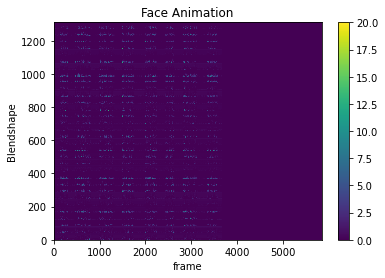

In [23]:
plot_result(x_2_masked.squeeze().T.detach())

In [ ]:
class SequenceWise(nn.Module):
    def __init__(self, module):
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.
        :param module: Module to apply input to.
        """
        super(SequenceWise, self).__init__()
        self.module = module

    def forward(self, x):
        t, n = x.size(0), x.size(1)
        x = x.view(t * n, -1)
        x = self.module(x)
        x = x.view(t, n, -1)
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        tmpstr += self.module.__repr__()
        tmpstr += ')'
        return tmpstr

class BatchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.LSTM, bidirectional=False, batch_norm=True):
        super(BatchRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.batch_norm = SequenceWise(nn.BatchNorm1d(input_size)) if batch_norm else None
        self.rnn = rnn_type(input_size=input_size, hidden_size=hidden_size,
                            bidirectional=bidirectional, bias=True)
        self.num_directions = 2 if bidirectional else 1

    def flatten_parameters(self):
        self.rnn.flatten_parameters()

    def forward(self, x, lengths):
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        # x = nn.utils.rnn.pack_padded_sequence(x, lengths, enforce_sorted=False)
        x, h = self.rnn(x)
        # x, _ = nn.utils.rnn.pad_packed_sequence(x)
        if self.bidirectional:
            x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)  # (TxNxH*2) -> (TxNxH) by sum
        return x

# Subtitute variables
sample_rate = 16000
window_size = .02
hidden_size = 1024
rnn_type = nn.LSTM
hidden_layers = 5

# Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
rnn_input_size = int(math.floor((sample_rate * window_size) / 2) + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
rnn_input_size *= 32

rnns = nn.Sequential(
            BatchRNN(
                input_size=rnn_input_size,
                hidden_size=hidden_size,
                rnn_type=rnn_type,
                bidirectional=True,
                batch_norm=False
            ),
            *(
                BatchRNN(
                    input_size=hidden_size,
                    hidden_size=hidden_size,
                    rnn_type=rnn_type,
                    bidirectional=True
                ) for x in range(hidden_layers - 1)
            )
        )

torch.Size([5841, 1, 1024])


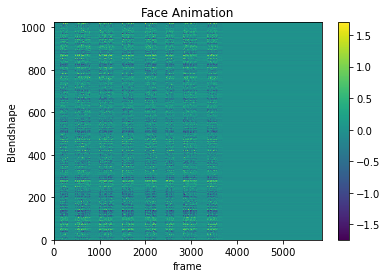

torch.Size([5841, 1, 1024])


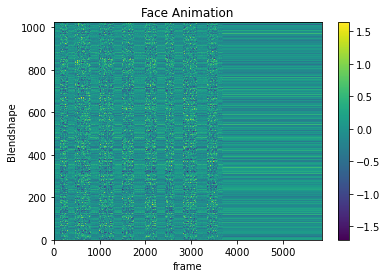

torch.Size([5841, 1, 1024])


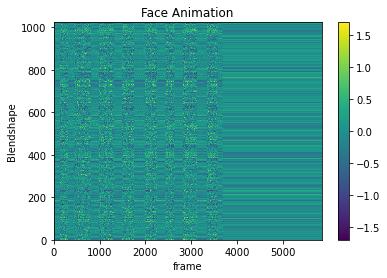

torch.Size([5841, 1, 1024])


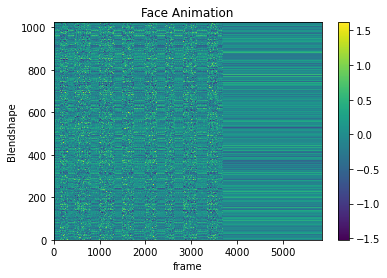

torch.Size([5841, 1, 1024])


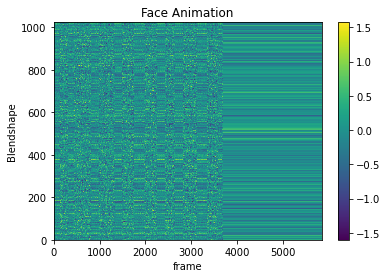

In [28]:
rnn_out = x_2_masked

for rnn in rnns:
    rnn_out = rnn(rnn_out, lengths)
    print(rnn_out.shape)
    plot_result(rnn_out.squeeze().T.detach())

In [29]:
class SequenceWise(nn.Module):
    def __init__(self, module):
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.
        :param module: Module to apply input to.
        """
        super(SequenceWise, self).__init__()
        self.module = module

    def forward(self, x):
        t, n = x.size(0), x.size(1)
        x = x.view(t * n, -1)
        x = self.module(x)
        x = x.view(t, n, -1)
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        tmpstr += self.module.__repr__()
        tmpstr += ')'
        return tmpstr

class BatchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.LSTM, bidirectional=False, batch_norm=True):
        super(BatchRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.batch_norm = SequenceWise(nn.BatchNorm1d(input_size)) if batch_norm else None
        self.rnn = rnn_type(input_size=input_size, hidden_size=hidden_size,
                            bidirectional=bidirectional, bias=True)
        self.num_directions = 2 if bidirectional else 1

    def flatten_parameters(self):
        self.rnn.flatten_parameters()

    def forward(self, x, lengths):
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, enforce_sorted=False)
        x, h = self.rnn(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)
        if self.bidirectional:
            x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)  # (TxNxH*2) -> (TxNxH) by sum
        return x

# Subtitute variables
sample_rate = 16000
window_size = .02
hidden_size = 1024
rnn_type = nn.LSTM
hidden_layers = 5

# Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
rnn_input_size = int(math.floor((sample_rate * window_size) / 2) + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
rnn_input_size *= 32

rnns = nn.Sequential(
            BatchRNN(
                input_size=rnn_input_size,
                hidden_size=hidden_size,
                rnn_type=rnn_type,
                bidirectional=True,
                batch_norm=False
            ),
            *(
                BatchRNN(
                    input_size=hidden_size,
                    hidden_size=hidden_size,
                    rnn_type=rnn_type,
                    bidirectional=True
                ) for x in range(hidden_layers - 1)
            )
        )

In [40]:
x_2_masked.shape, lengths

(torch.Size([5841, 1, 1312]), tensor([3672], dtype=torch.int32))

In [41]:
x = nn.utils.rnn.pack_padded_sequence(x_2_masked, lengths, enforce_sorted=False)

In [43]:
x

PackedSequence(data=tensor([[0.3452, 0.0469, 0.0903,  ..., 0.0307, 0.0134, 0.0272],
        [0.3320, 0.0000, 0.0000,  ..., 0.0362, 0.0421, 0.0175],
        [0.2457, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.2486, 0.1758,  ..., 0.0000, 0.0000, 0.0739],
        [0.0000, 0.1275, 0.1211,  ..., 0.0000, 0.0353, 0.0588],
        [0.1071, 0.0643, 0.1350,  ..., 0.1670, 0.1604, 0.1485]],
       grad_fn=<PackPaddedSequenceBackward>), batch_sizes=tensor([1, 1, 1,  ..., 1, 1, 1]), sorted_indices=tensor([0]), unsorted_indices=tensor([0]))

torch.Size([3672, 1, 1024])


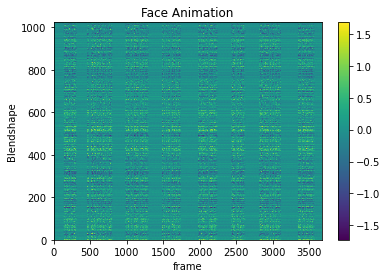

torch.Size([3672, 1, 1024])


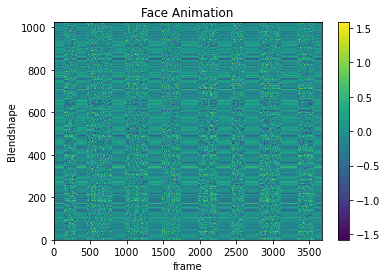

torch.Size([3672, 1, 1024])


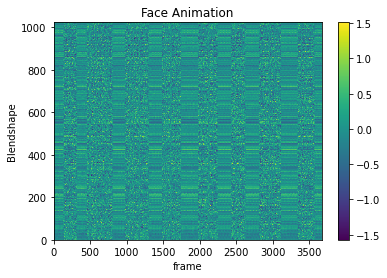

torch.Size([3672, 1, 1024])


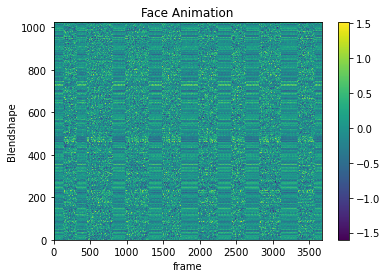

torch.Size([3672, 1, 1024])


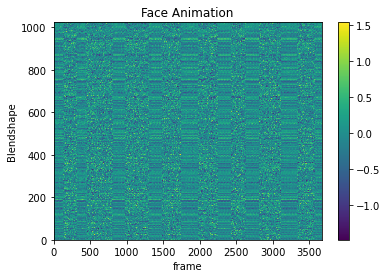

In [30]:
rnn_out = x_2_masked

for rnn in rnns:
    rnn_out = rnn(rnn_out, lengths)
    print(rnn_out.shape)
    plot_result(rnn_out.squeeze().T.detach())

In [31]:
rnn_out.shape

torch.Size([3672, 1, 1024])

In [44]:
encoder_out = rnn_out.permute(1, 0, 2).contiguous()
encoder_out.shape

torch.Size([1, 3672, 1024])

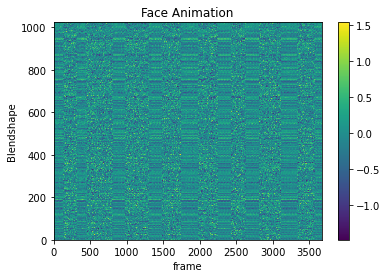

In [63]:
plot_result(encoder_out.squeeze().T.detach())

In [64]:
def interpolate_features(features, input_rate, output_rate, output_len=None):
    batch_size = features.shape[0]
    num_features = features.shape[2]
    input_len = features.shape[1]
    seq_len = input_len / float(input_rate)
    if output_len is None:
        output_len = int(seq_len * output_rate)
    input_timestamps = np.arange(input_len) / float(input_rate)
    output_timestamps = np.arange(output_len) / float(output_rate)
    output_features = np.zeros((batch_size, output_len, num_features))
    features_numpy = features.cpu().data.numpy()
    for batch in range(batch_size):
        for feat in range(num_features):
            output_features[batch][:, feat] = np.interp(output_timestamps,
                                                input_timestamps,
                                                features_numpy[batch][:, feat])
    return torch.from_numpy(output_features).float()

In [65]:
blendshape[0].shape, blendshape_len

(torch.Size([7012, 16]), tensor(4409, dtype=torch.int32))

In [68]:
blendshape = blendshape.unsqueeze(0)
len(blendshape[0])

7012

In [69]:
interpolate_out = interpolate_features(encoder_out, 50, 60, output_len=len(blendshape[0]))
interpolate_out.shape

torch.Size([1, 7012, 1024])

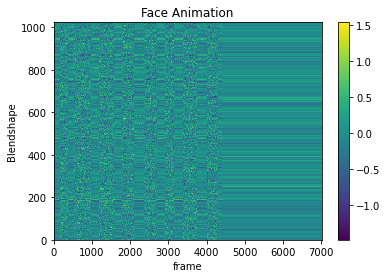

In [70]:
plot_result(interpolate_out[0].T.detach())

In [84]:
# def interpolate_features(features, input_rate, output_rate, output_len=None):
features = encoder_out
input_rate = 50
output_rate = 60
output_len = 4409

batch_size = features.shape[0]
num_features = features.shape[2]
input_len = features.shape[1]
seq_len = input_len / float(input_rate)
if output_len is None:
    output_len = int(seq_len * output_rate)
input_timestamps = np.arange(input_len) / float(input_rate)
# output_timestamps = np.arange(output_len) / float(output_rate)
output_timestamps = np.arange(output_len) / (output_len*input_rate/input_len)
output_features = np.zeros((batch_size, output_len, num_features))
features_numpy = features.cpu().data.numpy()
for batch in range(batch_size):
    for feat in range(num_features):
        output_features[batch][:, feat] = np.interp(output_timestamps,
                                            input_timestamps,
                                            features_numpy[batch][:, feat])
    # return torch.from_numpy(output_features).float()

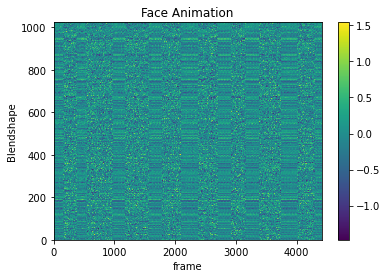

In [85]:
plot_result(output_features[0].T)

In [81]:
len(output_features[0])

4409

In [76]:
4409*50/3672

60.03540305010893

In [74]:
np.arange(10) / float(5)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])

In [75]:
np.arange(20) / float(6)

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
       1.66666667, 1.83333333, 2.        , 2.16666667, 2.33333333,
       2.5       , 2.66666667, 2.83333333, 3.        , 3.16666667])

In [73]:
3672/50

73.44

In [71]:
output_timestamps

array([0.00000000e+00, 1.66666667e-02, 3.33333333e-02, ...,
       1.16816667e+02, 1.16833333e+02, 1.16850000e+02])

In [60]:
np.zeros((batch_size, output_len, num_features)).shape

(1, 7012, 1024)

In [42]:
fc1_dim, fc2_dim = 1024, 1024
num_classes = 16

class ClipModule(nn.Module):
    def __init__(self, min_threshold, max_threshold):
        super(ClipModule, self).__init__()
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold

    
    def forward(self, x):
        return torch.clamp(x, min=self.min_threshold, max=self.max_threshold)

fully_connected = nn.Sequential(
    nn.AdaptiveAvgPool1d(fc1_dim),
    nn.Linear(fc1_dim, fc2_dim, bias=False),
    nn.ReLU6(),
    nn.Dropout(0.2),
    nn.Linear(fc2_dim, num_classes, bias=False),
)
fc = nn.Sequential(
    fully_connected,
    ClipModule(min_threshold=0, max_threshold=1),
)

In [43]:
fc_out = fc(interpolate_out)
fc_out.shape

torch.Size([1, 5028, 16])

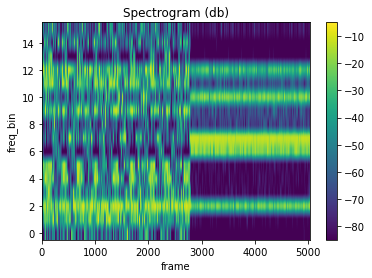

In [44]:
plot_spectrogram(fc_out[0].T.detach())

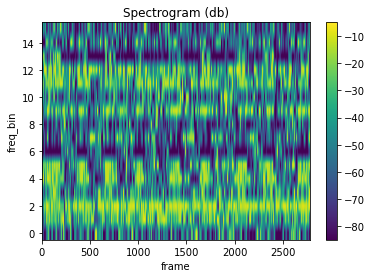

In [45]:
plot_spectrogram(fc_out[0][:2781].T.detach())

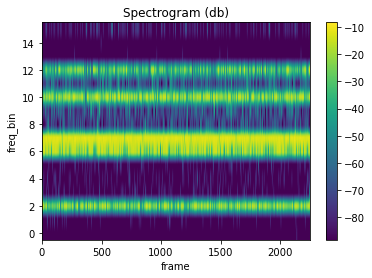

In [46]:
plot_spectrogram(fc_out[0][2781:].T.detach())